This notebook is used to train a CNN model to classify viral sequences of of dengue and zika virus.

### Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# FOR COLAB NOTEBOOKS

# Code for colab to mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [48]:
# Define the path to your zip file and the target directory for extraction
data_directory = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi'

# Load the numpy arrays with allow_pickle=True
cnn_labels = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/cnn_labels.npy', allow_pickle=True)
cnn_sequences = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/cnn_sequences.npy', allow_pickle=True)
cnn_accessions = np.load('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/cnn_accessions.npy', allow_pickle=True)
processed_dna_sequences = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/processed_dna_sequences.csv'

### Encode the labels

Required:

1. cnn_labels

In [49]:
# --- 1. Encode string labels to numerical format and then to one-hot encoded vectors ---
# This part is crucial before training your model.
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(cnn_labels)
num_classes = len(label_encoder.classes_) # Get the total number of unique HA types

# Convert integer labels to one-hot encoded vectors
one_hot_labels = to_categorical(integer_encoded_labels, num_classes=num_classes)

print(f"Original labels (first 5): {cnn_labels[:5]}")
print(f"Integer encoded labels (first 5): {integer_encoded_labels[:5]}")
print(f"Classes: {label_encoder.classes_}")
print(f"One-hot encoded labels (first 5):\n{one_hot_labels[:5]}")
print(f"Shape of one-hot encoded labels: {one_hot_labels.shape}")

Original labels (first 5): ['Dengue1' 'Dengue1' 'Dengue1' 'Dengue1' 'Dengue1']
Integer encoded labels (first 5): [0 0 0 0 0]
Classes: ['Dengue1' 'Dengue2' 'Dengue3' 'Dengue4' 'JapaneseEncephalitisVirus'
 'WestNileVirus' 'Zika']
One-hot encoded labels (first 5):
[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]
Shape of one-hot encoded labels: (7853, 7)


### Create Training, Validation, Test sets

Requirements

1. cnn_sequences (vectorized DNA sequences)

In [50]:
# --- 2. Split data into training, validation, and test sets ---
# Example: 70% train, 15% validation, 15% test
# Add an extra dimension to cnn_sequences to make it (samples, height, width, channels)
# For Conv2D, we typically treat (sequence_length, features) as (height, width, channels)
# so we add a width of 1: (samples, sequence_length, 1, features)
# The input shape to Conv2D will then be (sequence_length, 1, features)

X_reshaped = np.expand_dims(cnn_sequences, axis=2) # Add a new dimension at index 2 (width)
# Now X_reshaped shape is (num_samples, 1820, 1, 4)

# --- Optional: Sample data per class before splitting ---
# This section is added to allow sampling based on class distribution.
# You can uncomment and modify this section if you want to sample a specific number of samples per class.
# Note: Ensure that the number of samples you request per class does not exceed the available samples for that class.


# Create a pandas DataFrame to easily group by labels and sample
data_df = pd.DataFrame({
    'sequence': list(X_reshaped), # Store sequences as list in dataframe
    'label': cnn_labels,
    'accession': cnn_accessions
})

# Define the number of samples you want per class
samples_per_class = {
    'Dengue1': 500,
    'Dengue2': 500,
    'Dengue3': 500,
    'Dengue4': 250,
    'Zika': 370,
    'JapaneseEncephalitisVirus': 500,
    'WestNileVirus': 500
}

# Sample data from each class
sampled_data_list = []
for class_name, num_samples in samples_per_class.items():
    class_data = data_df[data_df['label'] == class_name]
    # Ensure num_samples does not exceed available samples
    num_samples_to_sample = min(num_samples, len(class_data))
    if num_samples_to_sample > 0: # Only sample if there are samples available for this class
        sampled_data = class_data.sample(n=num_samples_to_sample, random_state=42) # Add random_state for reproducibility
        sampled_data_list.append(sampled_data)

# Check if any data was sampled
if not sampled_data_list:
    print("Error: No samples were selected based on the specified classes and sample counts.")
    # Fallback to using original data if sampling resulted in an empty dataset,
    # or handle as an error depending on desired behavior.
    X_split, y_split, acc_split = X_reshaped, one_hot_labels, cnn_accessions
    print("Using original data for splitting.")
else:
    # Concatenate the sampled dataframes
    sampled_data_df = pd.concat(sampled_data_list)

    # Shuffle the sampled data to ensure randomness before splitting
    sampled_data_df = sampled_data_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Extract the sampled sequences, labels, and accessions
    X_sampled = np.array(list(sampled_data_df['sequence']))
    y_sampled_labels = sampled_data_df['label'].values
    acc_sampled = sampled_data_df['accession'].values

    # Encode the sampled labels (same process as before but on sampled labels)
    # Ensure label_encoder is fitted on the sampled labels
    label_encoder = LabelEncoder() # Re-initialize or use the existing one
    integer_encoded_labels_sampled = label_encoder.fit_transform(y_sampled_labels)
    # Get num_classes from the fitted label_encoder
    num_classes = len(label_encoder.classes_)
    one_hot_labels_sampled = to_categorical(integer_encoded_labels_sampled, num_classes=num_classes)

    X_split, y_split, acc_split = X_sampled, one_hot_labels_sampled, acc_sampled # Use sampled data for splitting


# X_split, y_split, acc_split = X_reshaped, one_hot_labels, cnn_accessions # Uncomment this line if NOT sampling


X_train, X_temp, y_train, y_temp, acc_train, acc_temp = train_test_split(
    X_split, y_split, acc_split, test_size=0.3, random_state=42, stratify=y_split
)
X_val, X_test, y_val, y_test, acc_val, acc_test = train_test_split(
    X_temp, y_temp, acc_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nReshaped input data shape for Conv2D: {X_reshaped.shape}")
# If you sampled, print the shape of the sampled data before splitting
if 'X_sampled' in locals():
     print(f"Sampled data shape before split: X={X_sampled.shape}, y={one_hot_labels_sampled.shape}, acc={acc_sampled.shape}")

print(f"Train set shape: X={X_train.shape}, y={y_train.shape}, acc={acc_train.shape}")
print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}, acc={acc_val.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}, acc={acc_test.shape}")


Reshaped input data shape for Conv2D: (7853, 11520, 1, 4)
Sampled data shape before split: X=(3120, 11520, 1, 4), y=(3120, 7), acc=(3120,)
Train set shape: X=(2184, 11520, 1, 4), y=(2184, 7), acc=(2184,)
Validation set shape: X=(468, 11520, 1, 4), y=(468, 7), acc=(468,)
Test set shape: X=(468, 11520, 1, 4), y=(468, 7), acc=(468,)


### Model Structure

## A) Fixed Structure Model

In [53]:

# --- 3. Define the CNN Model Structure ---

# Input shape for Conv2D should be (height, width, channels)
# Here, 'height' is your sequence length, 'width' is 1 (the dummy dimension we added),
# and 'channels' is 4 (for A, C, G, T).
input_shape_for_conv2d = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

model = models.Sequential()

# Input Layer: Specifies the expected shape of individual samples (excluding batch size)
model.add(layers.Input(shape=input_shape_for_conv2d))

# Convolutional Layers
model.add(layers.Conv2D(32, kernel_size=(10, 1), strides=(5, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Print a summary of the model to see the layer outputs and parameter counts
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 2304, 1, 32)    │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1152, 1, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     2,359,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,361,127 (9.01 MB)

 Trainable params: 2,361,127 (9.01 MB)

 Non-trainable params: 0 (0.00 B)

## B) Flexible Structure Model

In [37]:
# --- 3. Define the CNN Model Structure (Flexible Length) ---

# Input shape for Conv2D should be (height, width, channels)
# Here, 'height' is your sequence length, 'width' is 1 (the dummy dimension we added),
# and 'channels' is 4 (for A, C, G, T).
# To make the model flexible to sequence length, we can use None for the sequence length dimension (height).
input_shape_for_conv2d_flexible = (None, X_train.shape[2], X_train.shape[3]) # Use None for flexible height

model = models.Sequential()

# Input Layer: Specifies the expected shape of individual samples (excluding batch size)
# Use the flexible input shape
model.add(layers.Input(shape=input_shape_for_conv2d_flexible))

# Convolutional Layers
# Keep the Conv2D and MaxPooling2D layers as they can operate on variable height
model.add(layers.Conv2D(32, kernel_size=(21, 1), strides=(10, 1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 1)))

# Replace Flatten with Global Average Pooling 1D
# We apply GlobalAveragePooling1D on the output of MaxPooling2D.
# The output of MaxPooling2D has shape (None, height, 1, filters).
# We want to pool over the 'height' dimension (axis 1).
# Since the width dimension is 1, we can treat it as a 1D sequence of features for pooling.
# Keras GlobalAveragePooling1D expects input (batch_size, steps, features).
# Our MaxPooling2D output is effectively (batch_size, height, 1, filters).
# We need to remove the width dimension (axis 2) before passing to GlobalAveragePooling1D.
model.add(layers.Permute((1, 3, 2))) # Rearrange dimensions to (None, height, filters, 1)
model.add(layers.Reshape((-1, 32))) # Reshape to (None, height, filters) for GlobalAveragePooling1D
model.add(layers.GlobalAveragePooling1D()) # Pools over the height dimension


# Dense Layers (now connected after Global Average Pooling)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Print a summary of the model to see the layer outputs and parameter counts
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, None, 1, 32)    │         2,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, 1, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, None, 32, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,287 (20.65 KB)

 Trainable params: 5,287 (20.65 KB)

 Non-trainable params: 0 (0.00 B)

Notes on the flexible structure model

Gemini:

It's interesting that the flexible model shows worse performance. There could be a few reasons for this, related to the change from a Flatten layer to GlobalAveragePooling1D:

Information Loss: The Flatten layer preserves the spatial relationships of the features learned by the convolutional layers to some extent before feeding them to the dense layers. GlobalAveragePooling1D, on the other hand, averages the features across the entire sequence length. While this makes the model flexible to length, it discards all spatial information about where in the sequence a particular feature occurred. If the location of certain patterns in the DNA sequence is important for classification, averaging them out could hurt performance.

Reduced Model Capacity: Replacing a large number of connections from the Flatten layer to the first dense layer with the more constrained GlobalAveragePooling1D (which outputs a fixed number of values equal to the number of filters) might reduce the model's capacity to learn complex patterns, especially if the original fixed-length model was well-suited to the data.
Dataset Characteristics: Your dataset might have sequences where the position of distinguishing features is relatively consistent. In such cases, a fixed-length model that implicitly learns these positional dependencies through the Flatten layer might perform better than a model that averages across all positions.

Training Differences: Although you used the same compilation settings, subtle differences in initialization or the training process itself could contribute. However, the architectural change is the most likely primary driver of a significant performance difference.

In essence, while GlobalAveragePooling1D provides flexibility, it sacrifices the ability to learn position-dependent features. If positional information is key for classifying these viral sequences, the fixed-structure model with Flatten might be better suited, provided all input sequences can be consistently padded or truncated to the fixed length.

In [ ]:
# prompt: visualize model architecture

!pip install pydot graphviz
!apt-get install graphviz -y

tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

### Model Compilation - activation, learning rate, and metrics

In [54]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nModel compiled successfully.")



Model compiled successfully.


### Model Training

In [55]:
# --- 5. Train the Model ---
# Epochs: The number of times the training algorithm will work through the entire training dataset.
# Batch Size: The number of samples per gradient update. A typical value is 32 or 64.
# Validation Data: Pass the validation set (X_val, y_val) to monitor performance on unseen data during training.
epochs = 10
batch_size = 50 # You can experiment with different batch sizes

print(f"\nStarting training for {epochs} epochs with batch size {batch_size}...")

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))

print("\nTraining finished.")

# You can access the training history using the 'history' object
# print(history.history) # This will print loss and accuracy for each epoch




Starting training for 10 epochs with batch size 50...
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.6526 - loss: 1.0587 - val_accuracy: 0.9274 - val_loss: 0.2681
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 274ms/step - accuracy: 0.9505 - loss: 0.2049 - val_accuracy: 0.9509 - val_loss: 0.1642
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 13s 297ms/step - accuracy: 0.9832 - loss: 0.1038 - val_accuracy: 0.9679 - val_loss: 0.1184
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - accuracy: 0.9962 - loss: 0.0577 - val_accuracy: 0.9701 - val_loss: 0.0960
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 277ms/step - accuracy: 0.9963 - loss: 0.0390 - val_accuracy: 0.9744 - val_loss: 0.0801
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 246ms/step - accuracy: 1.0000 - loss: 0.0194 - val_accuracy: 0.9722 - val_loss: 0.0698
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 22s 293ms/step - accuracy: 1.0000 - loss: 0.0156 - val_accuracy: 0.9722 - val_loss: 0.0683
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 

In [56]:
#save the model

model.save('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model4_flavi.keras')


### Training and validation results and analysis

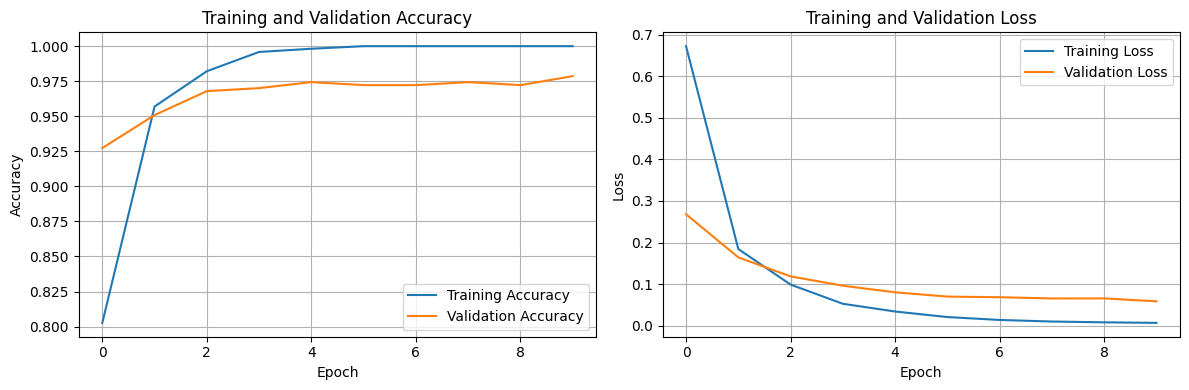

In [57]:
# prompt: plot training and validation loss and accuracy graphs

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Test evaluation and analysis

In [58]:
# Load the model
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model4_flavi.keras')



In [59]:
# 1. Get predictions from the model
# model.predict returns probabilities for each class
y_pred_probabilities = model.predict(X_test)

# 2. Convert probabilities to predicted class labels
# np.argmax will give you the index of the highest probability
predicted_integer_labels = np.argmax(y_pred_probabilities, axis=1)

# 3. If you want to see the human-readable HA types,
# use the label_encoder to inverse transform the integer labels
predicted_virus_types = label_encoder.inverse_transform(predicted_integer_labels)

# 4. Get the true labels in human-readable format for comparison
true_integer_labels = np.argmax(y_test, axis=1) # Convert y_test back from one-hot to integer
true_virus_types = label_encoder.inverse_transform(true_integer_labels)


# Overall model performance
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

Test Loss: 0.1172
Test Accuracy: 0.9615


In [60]:
# prompt: # prompt: please generate the above code, but i want the accession number of the samples

print("\n--- Sample of Accession Numbers, Predictions, and True Labels ---")
for i in range(min(10, len(X_test))): # Print up to 10 samples
    print(f"Sample {i+1}:")
    print(f"  Accession Number: {acc_test[i]}") # Print the accession number
    print(f"  True Virus Type: {true_virus_types[i]}")
    print(f"  Predicted Virus Type: {predicted_virus_types[i]}")
    print(f"  Prediction Probabilities: {y_pred_probabilities[i]}")
    print("-" * 30)



--- Sample of Accession Numbers, Predictions, and True Labels ---
Sample 1:
  Accession Number: GU131825.1
  True Virus Type: Dengue1
  Predicted Virus Type: Dengue1
  Prediction Probabilities: [9.9918145e-01 1.7382877e-04 3.5183129e-04 2.2149613e-04 7.7203349e-06
 4.7643527e-05 1.5918607e-05]
------------------------------
Sample 2:
  Accession Number: HM488231.1
  True Virus Type: WestNileVirus
  Predicted Virus Type: WestNileVirus
  Prediction Probabilities: [3.9672082e-05 5.2226274e-06 1.2399370e-05 3.3007549e-05 1.8058880e-05
 9.9982548e-01 6.6115310e-05]
------------------------------
Sample 3:
  Accession Number: KX547486.1
  True Virus Type: WestNileVirus
  Predicted Virus Type: WestNileVirus
  Prediction Probabilities: [2.25238509e-05 4.13121234e-06 4.04961565e-06 1.03419725e-05
 4.94050910e-05 9.99712586e-01 1.96979105e-04]
------------------------------
Sample 4:
  Accession Number: FJ744734.1
  True Virus Type: Dengue3
  Predicted Virus Type: Dengue3
  Prediction Probabili

In [62]:
# prompt: include in the above code, a way to compile and save the results in csv

import pandas as pd
import os

# Create a DataFrame with test results
results_df = pd.DataFrame({
    'Accession': acc_test,
    'True_Virus_Type': true_virus_types,
    'Predicted_Virus_Type': predicted_virus_types
})

# Add prediction probabilities for each class
for i, class_name in enumerate(label_encoder.classes_):
    results_df[f'Prob_{class_name}'] = y_pred_probabilities[:, i]

# Define the path to save the CSV file
results_directory = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/results'
results_csv_path = os.path.join(results_directory, 'model4_flavi_test_results.csv') # Define the full path including filename

# Create the directory if it doesn't exist
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
    print(f"Created directory: {results_directory}")


# Save the DataFrame to a CSV file
results_df.to_csv(results_csv_path, index=False)

print(f"\nTest results saved to: {results_csv_path}")

# Display the first few rows of the results DataFrame
print("\n--- Test Results DataFrame (first 5 rows) ---")
print(results_df.head())

Created directory: /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/results

Test results saved to: /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/results/model4_flavi_test_results.csv

--- Test Results DataFrame (first 5 rows) ---
    Accession True_Virus_Type Predicted_Virus_Type  Prob_Dengue1  \
0  GU131825.1         Dengue1              Dengue1      0.999181   
1  HM488231.1   WestNileVirus        WestNileVirus      0.000040   
2  KX547486.1   WestNileVirus        WestNileVirus      0.000023   
3  FJ744734.1         Dengue3              Dengue3      0.000063   
4  EU529701.1         Dengue2              Dengue2      0.000048   

   Prob_Dengue2  Prob_Dengue3  Prob_Dengue4  Prob_JapaneseEncephalitisVirus  \
0      0.000174      0.000352      0.000221                        0.000008   
1      0.000005      0.000012      0.000033                        0.000018   
2      0.000004      0.000004      0.000010                        0.000049   
3      0.000306      0.999583      

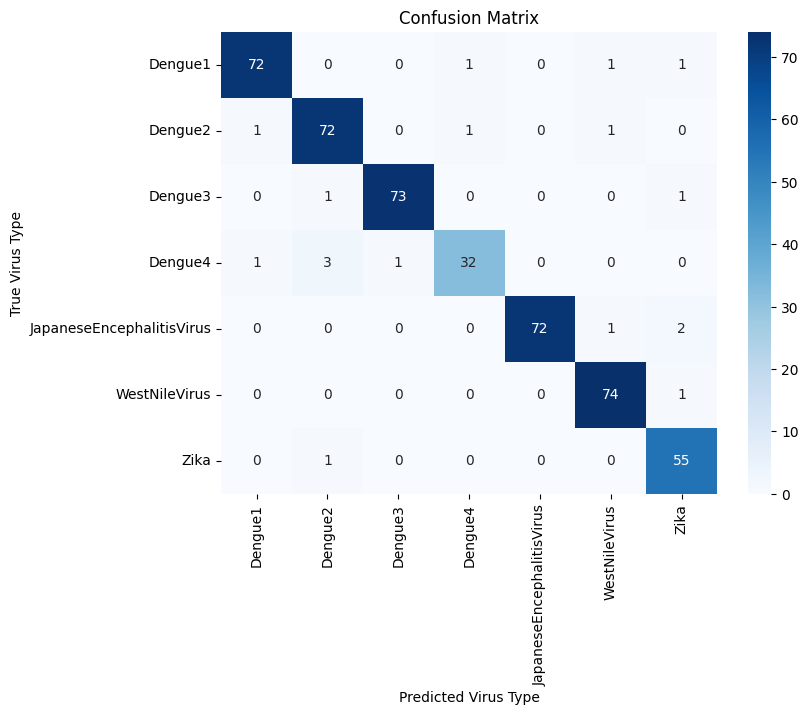


Confusion Matrix:


array([[72,  0,  0,  1,  0,  1,  1],
       [ 1, 72,  0,  1,  0,  1,  0],
       [ 0,  1, 73,  0,  0,  0,  1],
       [ 1,  3,  1, 32,  0,  0,  0],
       [ 0,  0,  0,  0, 72,  1,  2],
       [ 0,  0,  0,  0,  0, 74,  1],
       [ 0,  1,  0,  0,  0,  0, 55]])

In [63]:
# confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
# confusion_matrix expects true integer labels and predicted integer labels
cm = confusion_matrix(true_integer_labels, predicted_integer_labels)

# Get the class names (HA types) from the label encoder
class_names = label_encoder.classes_

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Virus Type')
plt.ylabel('True Virus Type')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion Matrix:")
cm


Weighted F1 Score: 0.9615


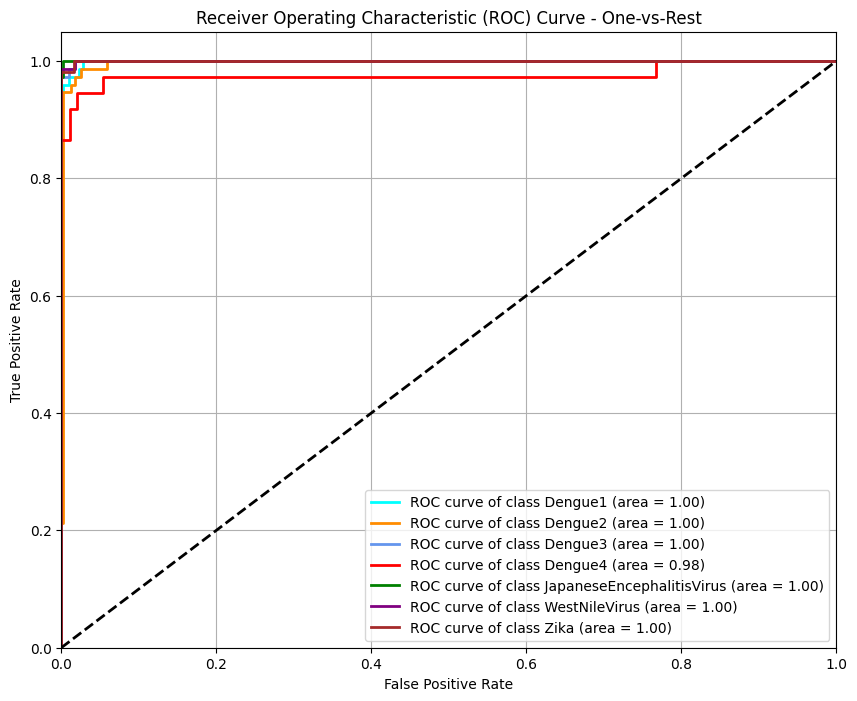


Mean ROC AUC (One-vs-Rest): 0.9959


In [64]:
import numpy as np
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate F1 Score
# F1 score requires true labels and predicted labels.
# Since this is a multi-class problem, we can calculate F1 score in different ways:
# 'micro', 'macro', 'weighted', or 'samples'.
# 'macro' calculates metrics for each label, and finds their unweighted mean. This does not take label imbalance into account.
# 'weighted' calculates metrics for each label, and finds their average weighted by support (the number of true instances for each label). This alters 'macro' to account for label imbalance.
# Let's use 'weighted' as it's often more appropriate for imbalanced datasets (if yours is imbalanced).
# You can change 'average' parameter based on your needs.
f1 = f1_score(true_integer_labels, predicted_integer_labels, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")

# Calculate ROC AUC
# ROC AUC is typically defined for binary classification problems.
# For multi-class classification, you can calculate ROC AUC per class (one-vs-rest or one-vs-one).
# One-vs-Rest (OvR) is common: Calculate the ROC AUC for each class against all other classes combined.
# The `roc_curve` and `auc` functions from scikit-learn are designed for binary classification.
# To do OvR, you need to iterate through each class.

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# y_test contains one-hot encoded true labels
# y_pred_probabilities contains the predicted probabilities for each class

for i in range(num_classes):
    # Get true labels for the current class (1 if it's the class, 0 otherwise)
    y_true_class = y_test[:, i]
    # Get predicted probabilities for the current class
    y_score_class = y_pred_probabilities[:, i]

    # Add print statements to check shapes
    # print(f"Class {i} ({label_encoder.classes_[i]}):")
    # print(f"  Shape of y_true_class: {y_true_class.shape}")
    # print(f"  Shape of y_score_class: {y_score_class.shape}")


    # Compute ROC curve for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_class, y_score_class)

    # Compute ROC AUC for the current class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'] # Define colors for each class
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2) # Plot random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - One-vs-Rest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Optional: Calculate the average ROC AUC (e.g., macro-average)
# This averages the ROC AUC scores across all classes.
# You might need to handle potential issues like division by zero if a class has no samples in the test set.
mean_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMean ROC AUC (One-vs-Rest): {mean_roc_auc:.4f}")

### Observation

Perhaps the model is a bit over powered.

note: it needs a not-flavi category because this current model will still give false positives if a non-flavi viral genome was given.

### (Extra) Activation Heatmap

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def get_feature_maps(model, layer_name, input_data):
    """
    Gets the feature maps (activations) from a specified layer in the model.

    Args:
        model (tf.keras.Model): The trained Keras model.
        layer_name (str): The name of the layer from which to extract feature maps.
        input_data (np.ndarray): The input data for which to get activations (e.g., a single sample).
                                 Shape should match the model's input shape (e.g., (1, height, width, channels)).

    Returns:
        np.ndarray: The feature maps from the specified layer. Returns None if the layer is not found.
    """
    try:
        # Create a model that outputs the activations of the specified layer
        feature_map_model = tf.keras.models.Model(
            inputs=model.inputs,
            outputs=model.get_layer(layer_name).output
        )
    except ValueError:
        print(f"Error: Layer '{layer_name}' not found in the model.")
        print("Available layers:")
        for layer in model.layers:
            print(f"- {layer.name}")
        return None
    except Exception as e:
        print(f"Error creating feature map model: {e}")
        return None

    # Get the feature maps for the given input data
    feature_maps = feature_map_model.predict(input_data)

    return feature_maps

def visualize_feature_maps(feature_maps, num_to_visualize=8):
    """
    Visualizes a subset of feature maps.

    Args:
        feature_maps (np.ndarray): The feature maps to visualize.
                                   Shape: (batch_size, height, width, channels).
                                   We assume batch_size is 1 for visualizing a single sample.
        num_to_visualize (int): The maximum number of feature maps to display.
    """
    if feature_maps is None or feature_maps.shape[0] != 1:
        print("Invalid feature maps data for visualization.")
        return

    # Remove the batch dimension
    feature_maps = feature_maps[0] # Shape becomes (height, width, channels)

    # For our DNA sequence case, the shape is (sequence_length, 1, filters)
    # We need to squeeze the width dimension (axis 1) to get (sequence_length, filters)
    feature_maps = np.squeeze(feature_maps, axis=1) # Shape becomes (sequence_length, filters)

    num_filters = feature_maps.shape[-1]
    print(f"Visualizing up to {min(num_to_visualize, num_filters)} out of {num_filters} feature maps.")

    # Determine the layout for subplots (e.g., 2 rows, num_to_visualize/2 columns)
    display_grid = int(np.ceil(np.sqrt(min(num_to_visualize, num_filters))))
    fig, axes = plt.subplots(display_grid, display_grid, figsize=(8, 8))
    axes = axes.flatten() # Flatten the axes array for easy iteration

    for i in range(min(num_to_visualize, num_filters)):
        ax = axes[i]
        # Display the i-th feature map.
        # Since it's (sequence_length, 1), we can treat it as an image.
        # Use aspect='auto' to fit the data.
        img = feature_maps[:, i] # Get the i-th filter's activations across the sequence
        im = ax.imshow(img[:, np.newaxis].T, cmap='viridis', aspect='auto', interpolation='nearest') # Reshape for imshow and transpose

        ax.set_title(f'Filter {i}')
        ax.axis('off') # Hide axes ticks and labels

        # Add a colorbar to each subplot
        fig.colorbar(im, ax=ax)


    # Hide any unused subplots
    for j in range(min(num_to_visualize, num_filters), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


# --- Example Usage for Feature Map Visualization ---
# Assuming you have your trained 'model', 'X_test', and 'cnn_accessions'
# from the previous code run.

if 'model' in locals() and 'X_test' in locals() and 'cnn_accessions' in locals():
    # Choose a sample from the test set to visualize (e.g., the first one)
    sample_index_viz = 0
    single_input_sequence_viz = X_test[sample_index_viz:sample_index_viz+1] # Keep batch dimension (1, 1820, 1, 4)
    accession_viz = cnn_accessions[sample_index_viz]

    print(f"\nVisualizing feature maps for sample index {sample_index_viz} (Accession: {accession_viz})")

    # Specify the name of the convolutional layer you want to visualize
    # Make sure this layer name exists in your model (e.g., 'conv2d')
    target_layer_name = 'conv2d' # Or the name of your convolutional layer

    # Get the feature maps
    feature_maps = get_feature_maps(model, target_layer_name, single_input_sequence_viz)

    # Visualize a subset of the feature maps
    if feature_maps is not None:
        visualize_feature_maps(feature_maps, num_to_visualize=10) # Visualize 16 feature maps
    else:
        print(f"Could not get feature maps for layer '{target_layer_name}'.")

else:
    print("Required variables (model, X_test, cnn_accessions) not found.")
    print("Please ensure the previous code blocks were run successfully.")

### EXTRA: FUNCTION/CLASS FORM

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers

class SequenceCNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(SequenceCNN, self).__init__()

        # Define layers
        self.conv1 = layers.Conv2D(64, kernel_size=(21, 1), strides=(10, 1), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D(pool_size=(2, 1))
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Define the forward pass
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output

# Example of how to use the object-oriented model:
# Assuming you have input_shape_for_conv2d and num_classes defined from previous steps

# Create an instance of the model
# object_oriented_model = SequenceCNN(num_classes)

# You can build the model by calling it with a dummy input with the correct shape
# object_oriented_model.build((None,) + input_shape_for_conv2d) # None for batch size

# Compile the model
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# object_oriented_model.compile(optimizer=optimizer,
#                               loss='categorical_crossentropy',
#                               metrics=['accuracy'])

# Print the summary
# object_oriented_model.summary()

In [ ]:
# Count the number of samples per class
classes, counts = np.unique(cnn_labels, return_counts=True)

print("Number of samples per class:")
for class_name, count in zip(classes, counts):
    print(f"- {class_name}: {count}")

# Testing Codes

In [65]:
def preprocess_sequence_for_cnn(sequence_string, target_length=11520):
    """
    Preprocesses a single DNA sequence string for input into the CNN model,
    padding or truncating to a target length.

    Args:
        sequence_string (str): The DNA sequence string (e.g., "AAGTTG...").
        target_length (int): The desired length of the sequence after padding/truncation.

    Returns:
        np.ndarray: The preprocessed sequence as a numpy array,
                    reshaped to (1, target_length, 1, 4) for the CNN.
    """
    # Define the mapping for one-hot encoding
    nucleotide_map = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]} # Handle 'N' as all zeros

    # Pad or truncate the sequence to the target length
    if len(sequence_string) < target_length:
        # Pad with 'N' to the target length
        padded_sequence = sequence_string + 'N' * (target_length - len(sequence_string))
    elif len(sequence_string) > target_length:
        # Truncate the sequence
        padded_sequence = sequence_string[:target_length]
    else:
        # Sequence is already the target length
        padded_sequence = sequence_string

    # Convert the padded/truncated sequence string to a list of one-hot encoded vectors
    encoded_sequence = [nucleotide_map.get(base.upper(), [0, 0, 0, 0]) for base in padded_sequence] # Handle unknown bases

    # Convert the list to a numpy array
    encoded_sequence_array = np.array(encoded_sequence, dtype=np.float32)

    # Reshape for the CNN: (1, target_length, 1, 4)
    # Add a batch dimension (1), a width dimension (1), and keep height (target_length) and channels (4)
    preprocessed_input = np.expand_dims(encoded_sequence_array, axis=0) # Add batch dimension
    preprocessed_input = np.expand_dims(preprocessed_input, axis=2) # Add width dimension

    return preprocessed_input

In [66]:
# Load the model
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model4_flavi.keras')

In [67]:
# Example Usage:
# Assuming you have a new sequence string you want to test
# Use a sequence of the same length as the training data (11520) or a different length to test padding/truncation
new_dna_sequence = "AAGTTGTTTCAGCGGTCTCCGTGAGCAATTTACCCGATAAAGCAAGCAGATTATTCGGTGTGGAACTCGAAAATCTTGTGGAGACCGAACGCCGTGAGTTCTCTTAAATTCGTAGCGTTAAGAAACACTGCATCAGTAGAAAAACTGTTGTTAGAATAGAAATCCTTTGTGTCAAGAGCCATTCAGGATGGCCATTTACAGTGGAGCGTAGAGGCTTTGACATGAATCGAGTTGTGCAGATGCCTTAAAGAAAAACATGAATCAACCGCTTAATCTTTCTTATCTTTTTCATCATGAAAGCAACACTGTCAAGCACATGCACAAATGGTTGAGACATCAGCGAAGATGGCTGCCTTGCTTGAAGAGCTTAGGCTGGATTTCATCAACCGAGATTCTCTTCCTTGCAAACAAACATGAACATTTAGGCTGCATCAGTAGAAAAATTGTTGTTAGAATAGAAATCCTTTGTGTCAAGAGCCATTCAGGATGGCCATTTACAGTGGAGCGTAGAGGCTTTGACATGAATCGAGTTGTGCAGATGCCTTAAAGAAAAACATGAATCAACCGCTTAATCTTTCTTATCTTTTTCATCATGAAAGCAACACTGTCAAGCACATGCACAAATGGTTGAGACATCAGCGAAGATGGCTGCCTTGCTTGAAGAGCTTAGGCTGGATTTCATCAACCGAGATTCTCTTCCTTGCAAACAAACATGAACATTTAGGCTGCATCAGTAGAAAAATTGTTGTTAGAATAGAAATCCTTTGTGTCAAGAGCCATTCAGGATGGCCATTTACAGTGGAGCGTAGAGGCTTTGACATGAATCGAGTTGTGCAGATGCCTTAAAGAAAAACATGAATCAACCGCTTAATCTTTCTTATCTTTTTCATCATGAAAGCAACACTGTCAAGCACATGCACAAATGGTTGAGACATCAGCGAAGATGGCTGCCTTGCTTGAAGAGCTTAGGCTGGATTTCATCAACCGAGATTCTCTTCCTTGCAAACAAACATGAACATTTAGGCTGCATCAGTAGAAAAATTGTTGTTAGAATAGAAATCCTTTGTGTCAAGAGCCATTCAGGATGGCCATTTACAGTGGAGCGTAGAGGCTTTGACATGAATCGAGTTGTGCAGATGCCTTAAAGAAAAACATGAATCAACCGCTTAATCTTTCTTATCTTTTTCATCATGAAAGCAACACTGTCAAGCACATGCACAAATGGTTGAGACATCAGCGAAGATGGCTGCCTTGCTTGAAGAGCTTAGGCTGGATTTCATCAACCGAGATTCTCTTCCTTGCAAACAAACATGAACATTTAGGCTGCATCAGTAGAAAAATTGTTGTTAGAATAGAAATCCTTTGTGTCAAGAGCCATTCAGGATGGCCATTTACAGTGGAGCGTAGAGGCTTTGACATGAATCGAGTTGTGCAGATGCCTTAAAGAAAAACATGAATCAACCGCTTAATCTTTCTTATCTTTTTCATCATGAAAGCAACACTGTCAAGCACATGCACAAATGGTTGAGACATCAGCGAAGATGGCTGCCTTGCTTGAAGAGCTTAGGCTGGATTTCATCAACCGAGATTCTCTTCCTTGCAAACAAACATGAACATTTAGGCTGCATCAGTAGAAAAATTGTTGTTAGAATAGAAATCCTTTGTGTCAAGAGCCATTCAGGATGGCCATTTACAGTGGAGCGTAGAGGCTTTGACATGAATCGAGTTGTGCAGATGCCTTAAAGAAAAACATGAATCAACCGCTTAATCTTTCTTATCTTTTTCATCATGAAAGCAACACTGTCAAGCACATGCACAAATGGTTGAGACATCAGCGAAGATGGCTGCCTTGCTTGAAGAGCTTAGGCTGGATTTCATCAACCGAGATTCTCTTCCTTGCAAACAAACATGAACATTTAGGCTGCATCAGTAGAAAAATTGTTGTTAGAATAGAAATCCTTTGTGTCAAGAGCCATTCAGGATGGCCATTTACAGTGGAGCGTAGAGGCTTTGACATGAATCGAGTTGTGCAGATGCCTTAAAGAAAAACATGAATCAACCGCTTAATCTTTCTTATCTTTTTCATCATGAAAGCAACACTGTCAAGCACATGCACAAATGGTTGAGACATCAGCGAAGATGGCTGCCTTGCTTGAAGAGCTTAGGCTGGATTTCATCAACCGAGATTCTCTTCCTTGCAAACAAACATGAACATTTAGGCTGCATCAGTAGAAAAATTGTTGTTAGAATAGAAATCCTTTGTGTCAAGAGCCATTCAGGATGGCCATTTACAGTGGAGCGTAGAGGCTTTDENGUE1"

# Specify the target length that the model was trained on
target_sequence_length = 11520 # This should match the sequence length of your training data (X_train.shape[1])

preprocessed_sequence = preprocess_sequence_for_cnn(new_dna_sequence, target_length=target_sequence_length)

print(f"Original sequence string length: {len(new_dna_sequence)}")
print(f"Preprocessed sequence shape for CNN: {preprocessed_sequence.shape}")

# Now you can use this preprocessed_sequence as input to your trained model's predict method
prediction = model.predict(preprocessed_sequence)
print(f"Prediction output shape: {prediction.shape}")
predicted_class_index = np.argmax(prediction)
predicted_virus_type = label_encoder.classes_[predicted_class_index]
print(f"Predicted Virus Type: {predicted_virus_type}")

Original sequence string length: 2318
Preprocessed sequence shape for CNN: (1, 11520, 1, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
Prediction output shape: (1, 7)
Predicted Virus Type: JapaneseEncephalitisVirus


In [68]:
# prompt: can you turn the testing codes into gradio app?

!pip install gradio
import gradio as gr
import tensorflow as tf
from tensorflow.keras import models
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import os
from google.colab import drive

# Mount Google Drive (if not already mounted)
try:
    drive.mount('/content/drive')
    print("Google Drive mounted.")
except:
    print("Google Drive already mounted or could not be mounted.")

# Define paths (adjust as necessary)
model_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model4_flavi.keras'
labels_path = '/content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/cnn_labels.npy' # Assuming labels are needed for LabelEncoder

# Load the trained model
try:
    model = models.load_model(model_path)
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model from {model_path}: {e}")
    model = None # Ensure model is None if loading fails

# Load the original labels to fit the LabelEncoder
try:
    cnn_labels = np.load(labels_path, allow_pickle=True)
    label_encoder = LabelEncoder()
    label_encoder.fit(cnn_labels)
    print(f"LabelEncoder fitted successfully with labels from {labels_path}")
except Exception as e:
    print(f"Error loading labels or fitting LabelEncoder from {labels_path}: {e}")
    label_encoder = None # Ensure label_encoder is None if loading fails


def preprocess_sequence_for_cnn(sequence_string, target_length=11520):
    """
    Preprocesses a single DNA sequence string for input into the CNN model,
    padding or truncating to a target length.

    Args:
        sequence_string (str): The DNA sequence string (e.g., "AAGTTG...").
        target_length (int): The desired length of the sequence after padding/truncation.

    Returns:
        np.ndarray: The preprocessed sequence as a numpy array,
                    reshaped to (1, target_length, 1, 4) for the CNN.
    """
    # Define the mapping for one-hot encoding
    nucleotide_map = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]} # Handle 'N' as all zeros

    # Pad or truncate the sequence to the target length
    if len(sequence_string) < target_length:
        # Pad with 'N' to the target length
        padded_sequence = sequence_string + 'N' * (target_length - len(sequence_string))
    elif len(sequence_string) > target_length:
        # Truncate the sequence
        padded_sequence = sequence_string[:target_length]
    else:
        # Sequence is already the target length
        padded_sequence = sequence_string

    # Convert the padded/truncated sequence string to a list of one-hot encoded vectors
    encoded_sequence = [nucleotide_map.get(base.upper(), [0, 0, 0, 0]) for base in padded_sequence] # Handle unknown bases

    # Convert the list to a numpy array
    encoded_sequence_array = np.array(encoded_sequence, dtype=np.float32)

    # Reshape for the CNN: (1, target_length, 1, 4)
    # Add a batch dimension (1), a width dimension (1), and keep height (target_length) and channels (4)
    preprocessed_input = np.expand_dims(encoded_sequence_array, axis=0) # Add batch dimension
    preprocessed_input = np.expand_dims(preprocessed_input, axis=2) # Add width dimension

    return preprocessed_input

# Define the prediction function for Gradio
def predict_virus_type(dna_sequence):
    if model is None:
        return "Error: Model not loaded."
    if label_encoder is None:
        return "Error: LabelEncoder not fitted."

    try:
        # Preprocess the input sequence
        target_sequence_length = 11520 # This should match the model's expected input length
        preprocessed_sequence = preprocess_sequence_for_cnn(dna_sequence, target_length=target_sequence_length)

        # Get the prediction from the model
        prediction = model.predict(preprocessed_sequence)

        # Interpret the prediction
        predicted_class_index = np.argmax(prediction)
        predicted_virus_type = label_encoder.classes_[predicted_class_index]

        # Optionally, include probabilities in the output
        probability = prediction[0][predicted_class_index]
        return f"Predicted Virus Type: {predicted_virus_type} (Confidence: {probability:.4f})"

    except Exception as e:
        return f"An error occurred during prediction: {e}"

# Create the Gradio interface
if model and label_encoder:
    interface = gr.Interface(
        fn=predict_virus_type,
        inputs=gr.Textbox(lines=5, label="Enter DNA Sequence"),
        outputs=gr.Textbox(label="Prediction Result"),
        title="Virus Sequence Classifier",
        description="Enter a DNA sequence to classify the virus type (Dengue 1-4, Zika, Japanese Encephalitis Virus, West Nile Virus)."
    )

    # Launch the interface
    interface.launch(debug=True)
else:
    print("Cannot launch Gradio interface due to errors loading model or LabelEncoder.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.
Model loaded successfully from /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/models/model4_flavi.keras
LabelEncoder fitted successfully with labels from /content/drive/MyDrive/Colab Notebooks/VectorizeDNA/data_flavi/cnn_labels.npy
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b5ad047f2b1b31b1d5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (h

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b5ad047f2b1b31b1d5.gradio.live
